# Mass spec 6 samples analysis

### Imports and environment setup

- Date of run: 2025-03-02
- Environment: python 3.12
- Packages required: pandas, numpy, seaborn, matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

Both the MS and ELISA+metadata matrices were uploaded and some transformations to clean column names are done.

In [2]:
protein_matrix = pd.read_csv('./data/protein_matrix.csv', index_col=1, header=0)

In [3]:
protein_matrix = protein_matrix.T[3:].T
protein_matrix.columns = protein_matrix.columns.str.replace('D:\\2025NK010\\', '')
protein_matrix.columns = protein_matrix.columns.str.replace('_01_500ng.raw', '')
protein_matrix = protein_matrix.T


In [4]:
samples = pd.read_csv('./data/samples.csv', index_col=1, header=0)

## Samples analysis

We will analyze in MS the number of missing values and identities distributions.

In [5]:
# For each sample in the protein_matrix, count the nans
def count_nans(series):
    return series.isna().sum()

# Apply the function to each column in the protein_matrix
nan_counts = protein_matrix.T.apply(count_nans)
nan_counts

2025NK010_EVCO_001     667
2025NK010_EVCO_002    3191
2025NK010_EVCO_003    1452
2025NK010_EVCO_004     594
2025NK010_EVCO_005    1152
2025NK010_EVCO_006    1173
dtype: int64

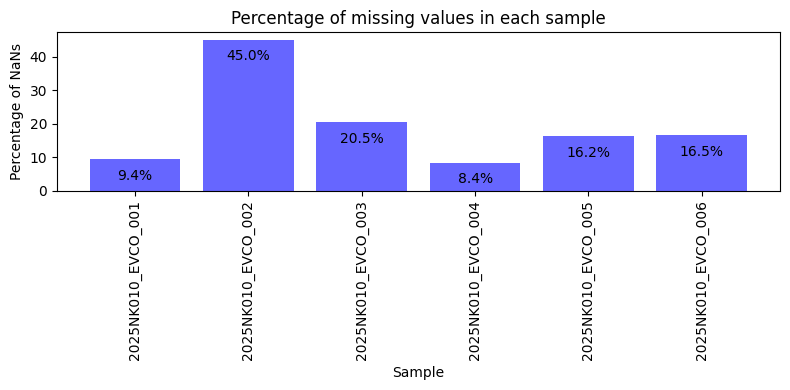

In [6]:

# Calculate the percentage of NaNs for each sample
nan_percentage = (nan_counts / protein_matrix.T.shape[0]) * 100
# Plot barplot of nan percentage
plt.figure(figsize=(8,4))
# Fulfill the bars with the percentage of NaNs
plt.bar(nan_percentage.index, nan_percentage.values, color='blue', alpha=0.6)
# Add percentage labels on top of the bars
for i, v in enumerate(nan_percentage.values):
    plt.text(i, v - 7, f"{v:.1f}%", ha='center', va='bottom')


plt.xticks(rotation=90)
plt.xlabel('Sample')
plt.ylabel('Percentage of NaNs')
plt.title('Percentage of missing values in each sample')
plt.tight_layout()
plt.show()

As can be observed, the number of missing values in the sample 2 is much higher than the rest.

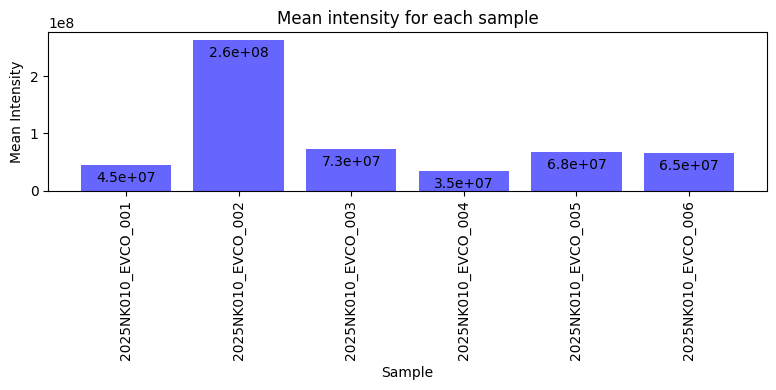

In [7]:
# Compute the mean intensity for each sample
mean_intensity = protein_matrix.T.mean(axis=0)
# Plot barplot of mean intensity
plt.figure(figsize=(8,4))
# Fulfill the bars with the mean intensity
plt.bar(mean_intensity.index, mean_intensity.values, color='blue', alpha=0.6)
# Add mean intensity labels on top of the bars
for i, v in enumerate(mean_intensity.values):
    # Add the same text but with scientific notation
    plt.text(i, v - 35000000, f"{v:.1e}", ha='center', va='bottom')
plt.xticks(rotation=90)
plt.xlabel('Sample')
plt.ylabel('Mean Intensity')
plt.title('Mean intensity for each sample')
plt.tight_layout()
plt.show()

The mean of intensities correlate with the percentage of missing values, are these two things related?

### Distributions of intensities, per sample

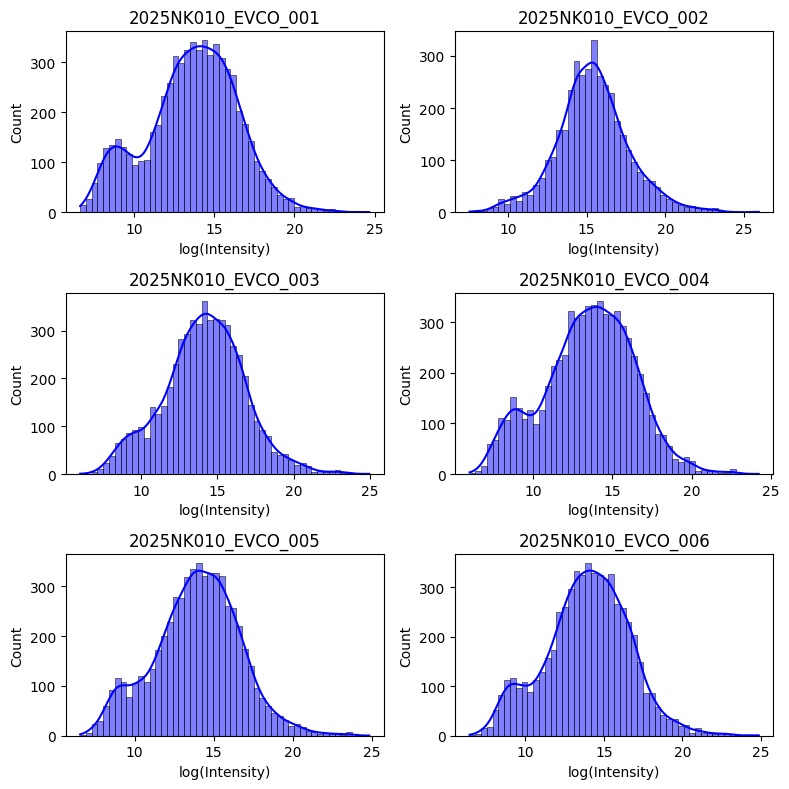

In [8]:
# Compute, withsubplots, distribution of intensities for each sample
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
axes = axes.flatten()
for i, sample in enumerate(protein_matrix.T.columns):
    sns.histplot(protein_matrix.T[sample].apply(lambda x : np.log(x+1)), bins=50, kde=True, ax=axes[i], color='blue')
    axes[i].set_title(sample)
    axes[i].set_xlabel('log(Intensity)')
    #axes[i].set_ylabel('Density')
plt.tight_layout()
plt.show()


Notably, in the sample 2, the distribution lacks the enriched left tail of low intensity proteins. 

## What happens for the interest biomarkers?

Let's analyze the distributions of intensities for the MMK interest biomarkers over the samples, in MS.

In [9]:
MMK_BIOMARKERS = ["HSPB1_HUMAN","AGRIN_HUMAN","KPYM_HUMAN","PERM_HUMAN","ADIPO_HUMAN","TIMP2_HUMAN", "MMP9_HUMAN"]
BENIGN_SAMPLES = ["2025NK010_EVCO_001", "2025NK010_EVCO_002", "2025NK010_EVCO_003"]
CANCER_SAMPLES = ["2025NK010_EVCO_004", "2025NK010_EVCO_005", "2025NK010_EVCO_006"]


In [10]:
mmk_biomarkers_df = protein_matrix.T.loc[MMK_BIOMARKERS]

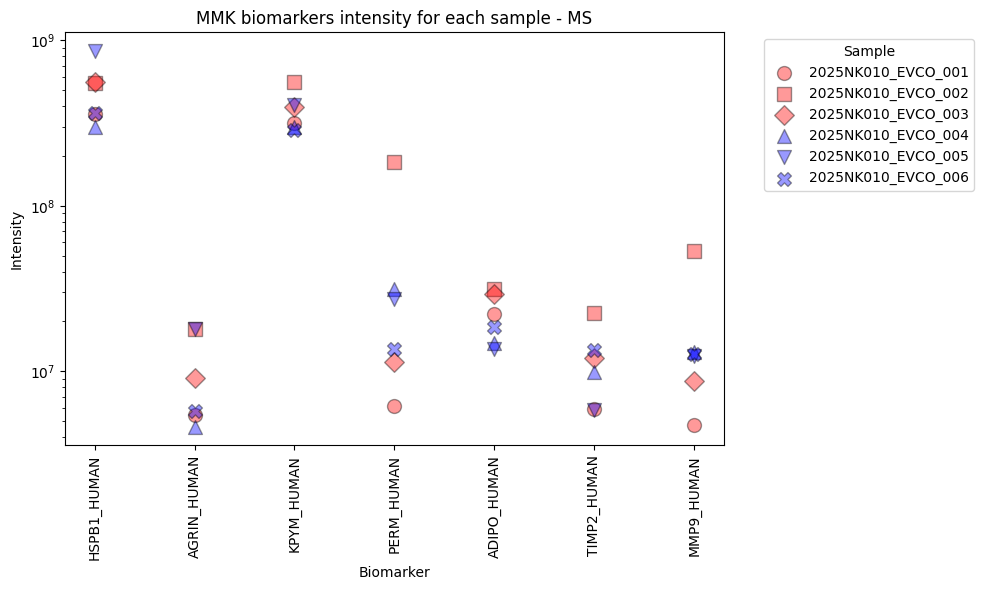

In [11]:
# Plot the MMK biomarkers, each sample a value in the x axis, 
# and the intensity in the y axis,
# with a different color for each sample
plt.figure(figsize=(10, 6))
# use red for benign samples and blue for cancer samples
palette = ["red" if sample in BENIGN_SAMPLES else "blue" for sample in mmk_biomarkers_df.columns]

markers = ['o', 's', 'D', '^', 'v', 'X']

# Plot each sample with a different color
for i, sample in enumerate(sorted(mmk_biomarkers_df.columns)):
    # scatter plot with the sample name as label
    # and the intensity as y value
    # and alpha = 0.7, and black border 1px
    # circles for benign samples and squares for cancer samples
    plt.scatter(mmk_biomarkers_df.index, 
                mmk_biomarkers_df[sample], 
                label=sample, 
                color=palette[i], 
                alpha=0.4, 
                edgecolor='black', 
                marker=markers[i],
                s=100,
                linewidth=1)
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Biomarker')
plt.ylabel('Intensity')
plt.title('MMK biomarkers intensity for each sample - MS')
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


And now let's do the same with the ELISA results we have obtained (normalized by total protein).

In [17]:
BIOMARKERS_MMK = ["HSPB1_MMK","AGRIN_MMK","KPYM_MMK","PERM_MMK","ADIPOQ_RUO","TIMP2_RUO", "MMP9_MMK"]
BIOMARKERS_MMK_n = ["HSPB1_MMK_n","AGRIN_MMK_n","KPYM_MMK_n","PERM_MMK_n","ADIPOQ_RUO_n","TIMP2_RUO_n", "MMP9_MMK_n"]


In [18]:
# normalizde BIOMARKERS_MMK by Total protein BCA mg/mL column
for bmk, bmk_n in zip(BIOMARKERS_MMK, BIOMARKERS_MMK_n):
    samples[bmk_n] = samples[bmk].div(samples["Total protein BCA mg/mL"], axis=0)
    

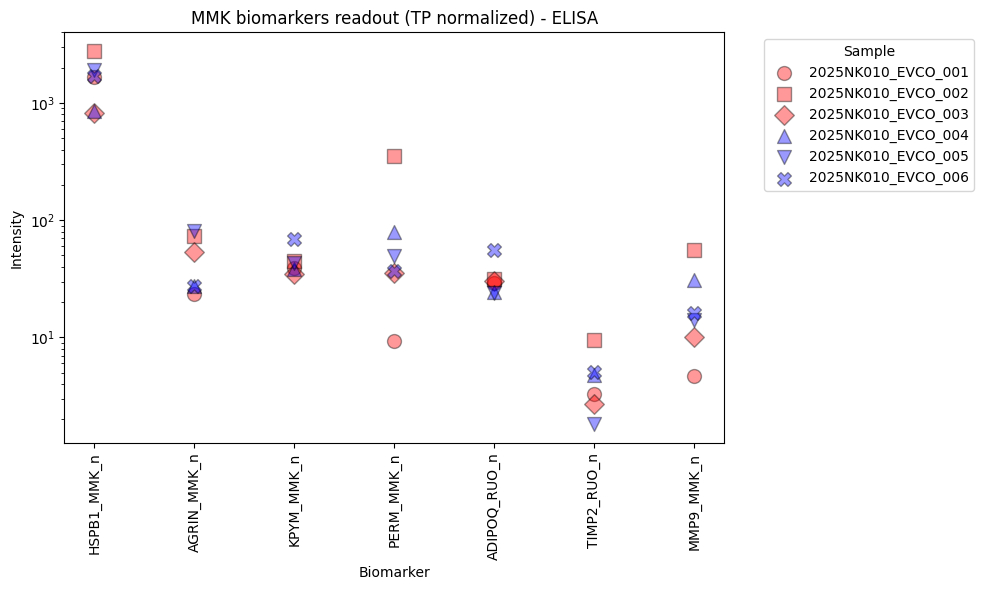

In [19]:
# Being BIOMARKERS_MMK the biomarkers of interest (the columns to look in the samples dataframe)
# and the index of the samples dataframe the samples to look for
# Do the very same plot as before but with the samples dataframe

plt.figure(figsize=(10, 6))
# use red for benign samples and blue for cancer samples
palette = ["red" if sample in BENIGN_SAMPLES else "blue" for sample in samples.index]
# make a list of six markers, one for each sample
markers = ['o', 's', 'D', '^', 'v', 'X']
# Set the style of the plot
# Plot each sample with a different color
for i, sample in enumerate(sorted(samples.index)):
    # scatter plot with the sample name as label
    # and the intensity as y value
    # and alpha = 0.7, and black border 1px
    # circles for benign samples and squares for cancer samples
    plt.scatter(BIOMARKERS_MMK_n, 
                samples.loc[sample, BIOMARKERS_MMK_n], 
                label=sample, 
                color=palette[i], 
                alpha=0.4, 
                edgecolor='black', 
                marker=markers[i],
                s=100,
                linewidth=1)
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Biomarker')
plt.ylabel('Intensity')
plt.title('MMK biomarkers readout (TP normalized) - ELISA')
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Now, let's do the same but comparing the MS and ELISA for each biomarker individually. Since they are expressed in different scales/units, we need to normalize their intensities to compare them.

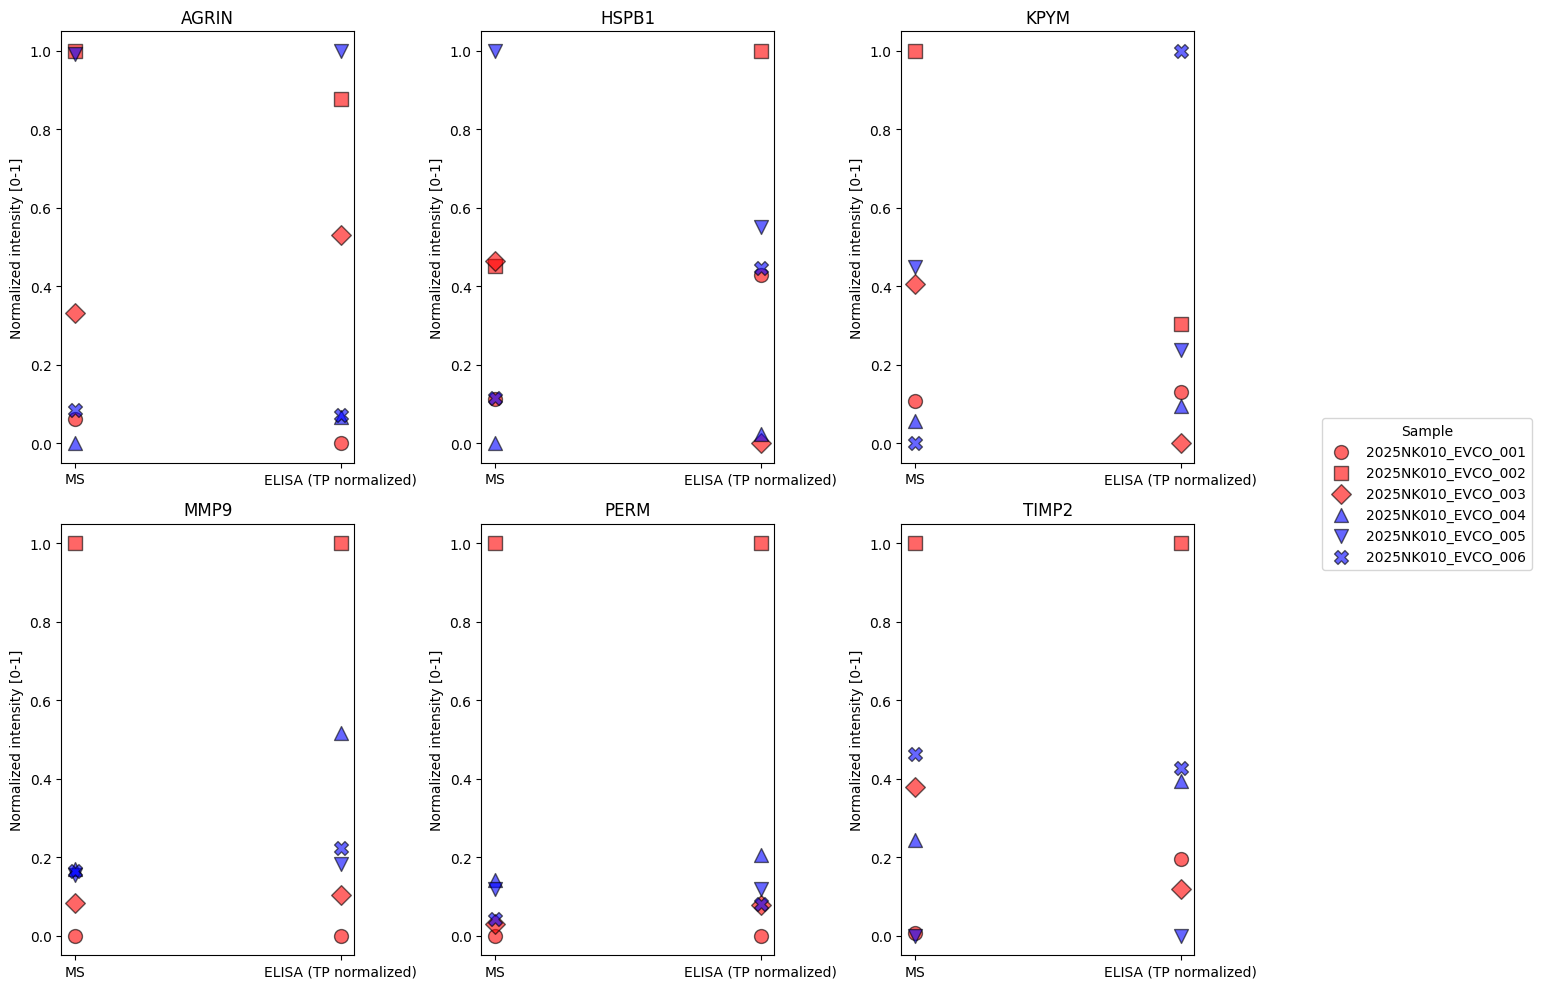

In [20]:
# Match biomarker roots in both datasets
mmk_biomarker_roots = {b.split('_')[0] for b in mmk_biomarkers_df.index}
elisa_biomarker_roots = {b.split('_')[0] for b in BIOMARKERS_MMK_n}
common_biomarkers = sorted(mmk_biomarker_roots & elisa_biomarker_roots)

# Build mappings from sample to color and marker
all_samples = list(mmk_biomarkers_df.columns)
color_map = {sample: "red" if sample in BENIGN_SAMPLES else "blue" for sample in all_samples}
unique_markers = ['o', 's', 'D', '^', 'v', 'X', '*', 'P', '<', '>']  # extend if needed
marker_map = {sample: unique_markers[i % len(unique_markers)] for i, sample in enumerate(all_samples)}

# Set up subplots
n_cols = 3
n_rows = int(np.ceil(len(common_biomarkers) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for idx, biomarker in enumerate(common_biomarkers):
    ax = axes[idx]

    # Get full biomarker names
    ms_name = [b for b in mmk_biomarkers_df.index if b.startswith(biomarker)][0]
    elisa_name = [b for b in BIOMARKERS_MMK_n if b.startswith(biomarker)][0]

    # Extract and normalize MS values
    ms_vals = mmk_biomarkers_df.loc[ms_name]
    ms_min, ms_max = ms_vals.min(), ms_vals.max()
    norm_ms = (ms_vals - ms_min) / (ms_max - ms_min) if ms_max != ms_min else ms_vals * 0

    # Extract and normalize ELISA values
    elisa_vals = samples[elisa_name]
    elisa_min, elisa_max = elisa_vals.min(), elisa_vals.max()
    norm_elisa = (elisa_vals - elisa_min) / (elisa_max - elisa_min) if elisa_max != elisa_min else elisa_vals * 0

    # Plot per sample
    for sample in all_samples:
        if sample not in samples.index:
            continue

        color = color_map[sample]
        marker = marker_map[sample]

        if sample in norm_ms:
            ax.scatter("MS", norm_ms[sample], color=color, marker=marker, s=100, edgecolor='black', linewidth=1, alpha=0.6, label=sample)
        if sample in norm_elisa:
            ax.scatter("ELISA (TP normalized)", norm_elisa[sample], color=color, marker=marker, s=100, edgecolor='black', linewidth=1, alpha=0.6)

    ax.set_title(biomarker)
    ax.set_ylabel("Normalized intensity [0-1]")
    ax.set_ylim(-0.05, 1.05)

# Remove unused axes
for j in range(len(common_biomarkers), len(axes)):
    fig.delaxes(axes[j])
    
# Store handles/labels from first subplot for global legend
handles, labels = [], []
if len(common_biomarkers) > 0:
    handles, labels = axes[0].get_legend_handles_labels()
    seen = {}
    filtered_handles = []
    filtered_labels = []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen[l] = True
            filtered_handles.append(h)
            filtered_labels.append(l)

# Adjust layout and add global legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on right for legend
fig.legend(filtered_handles, filtered_labels, title="Sample",
           loc='center left', bbox_to_anchor=(0.88, 0.5))
plt.show()
plt.show()


## Fold changes

A fold change greater than 1 indicates that the biomarker is upregulated in cancer, meaning it shows higher intensity in cancer samples. Conversely, a fold change less than 1 suggests downregulation in cancer, i.e., the biomarker is less abundant in cancer compared to benign samples. Fold change values are always positive since they represent ratios. However, to make interpretation more intuitive, log2-transformed fold changes are often used: in this scale, positive values indicate upregulation, negative values indicate downregulation, and zero means no change.

### Interest biomarkers fold change (MS vs ELISA)

In [21]:
import pandas as pd
import numpy as np

# Extract biomarker roots in common
ms_roots = {b.split('_')[0] for b in mmk_biomarkers_df.index}
elisa_roots = {b.split('_')[0] for b in BIOMARKERS_MMK_n}
common_biomarkers = sorted(ms_roots & elisa_roots)

# Prepare output
fc_results = []

for biomarker in common_biomarkers:
    # Get MS and ELISA full names
    ms_name = [b for b in mmk_biomarkers_df.index if b.startswith(biomarker)][0]
    elisa_name = [b for b in BIOMARKERS_MMK_n if b.startswith(biomarker)][0]

    # Extract MS values
    ms_benign = mmk_biomarkers_df[BENIGN_SAMPLES].loc[ms_name].values
    ms_cancer = mmk_biomarkers_df[CANCER_SAMPLES].loc[ms_name].values

    # Extract ELISA values
    elisa_benign = samples.loc[BENIGN_SAMPLES, elisa_name].values
    elisa_cancer = samples.loc[CANCER_SAMPLES, elisa_name].values

    # Compute fold changes
    ms_fc = np.nanmean(ms_cancer) / np.nanmean(ms_benign) if np.nanmean(ms_benign) != 0 else np.nan
    elisa_fc = np.nanmean(elisa_cancer) / np.nanmean(elisa_benign) if np.nanmean(elisa_benign) != 0 else np.nan

    # Apply log2 transformation
    ms_fc = np.log2(ms_fc) if ms_fc > 0 else np.nan
    elisa_fc = np.log2(elisa_fc) if elisa_fc > 0 else np.nan

    fc_results.append({
        "Biomarker": biomarker,
        "MS_FoldChange": ms_fc,
        "ELISA_FoldChange": elisa_fc,
        "Same sign fold change?": "Yes" if np.sign(ms_fc) == np.sign(elisa_fc) else "No",
    })

# Create a dataframe
fc_df = pd.DataFrame(fc_results)

# Show rounded values
fc_df = fc_df.round(3)

# Display it nicely
from IPython.display import display, HTML
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

fc_df


,Biomarker,MS_FoldChange,ELISA_FoldChange,Same sign fold change?
0,AGRIN,-0.201,-0.156,Yes
1,HSPB1,0.047,-0.238,No
2,KPYM,-0.351,0.331,No
3,MMP9,-0.815,-0.203,Yes
4,PERM,-1.475,-1.256,Yes
5,TIMP2,-0.470,-0.401,Yes


In [22]:
import pandas as pd
import numpy as np

fc_list = []

for biomarker in protein_matrix.T.index:
    # Coerce to numeric (convert invalid entries to NaN)
    values_benign = pd.to_numeric(protein_matrix.T.loc[biomarker, BENIGN_SAMPLES], errors='coerce').values
    values_cancer = pd.to_numeric(protein_matrix.T.loc[biomarker, CANCER_SAMPLES], errors='coerce').values

    # Skip if either group is entirely NaN or empty
    if np.isnan(values_benign).all() or np.isnan(values_cancer).all():
        continue

    mean_benign = np.nanmean(values_benign)
    mean_cancer = np.nanmean(values_cancer)

    if mean_benign == 0 or np.isnan(mean_benign) or np.isnan(mean_cancer):
        continue  # skip invalid cases

    fc = mean_cancer / mean_benign

    fc_list.append({
        "Biomarker": biomarker,
        "Mean_Benign": mean_benign,
        "Mean_Cancer": mean_cancer,
        "Log2_Fold_Change": np.log2(fc) if fc > 0 else np.nan,
    })

# Create dataframe and sort by FC
fc_df = pd.DataFrame(fc_list)
fc_df = fc_df.dropna()
fc_df = fc_df.sort_values(by="Log2_Fold_Change", ascending=False).round(3)


### Highest cancer upregulated fold changes

In [23]:
# Show top 20, no index displayed
fc_df.head(20)


,Biomarker,Mean_Benign,Mean_Cancer,Log2_Fold_Change
2407,LIMK2_HUMAN,2627.990,14900000.000,12.469
1752,PTN3_HUMAN,1885.490,1716277.185,9.830
1192,IGF1R_HUMAN,1799.070,676608.960,8.555
3704,KAZRN_HUMAN,3269.570,541000.000,7.370
4463,ARH40_HUMAN,5774.810,717947.410,6.958
169,S35U4_HUMAN,6688.690,639869.000,6.580
2502,RAB38_HUMAN,3403.990,312997.000,6.523
448,CAH12_HUMAN,1287.460,111642.000,6.438
2196,PCP4_HUMAN,2394.330,168667.000,6.138
4687,YIPF5_HUMAN,5885.195,388639.675,6.045


### Highest benign upregulated fold changes

In [24]:
# Show top 20 downregulated
fc_df.tail(20)



,Biomarker,Mean_Benign,Mean_Cancer,Log2_Fold_Change
3001,SEC20_HUMAN,303020.000,8159.930,-5.215
2076,PACR_HUMAN,23700000.000,623467.500,-5.248
3056,SG2A2_HUMAN,222576666.667,5700000.000,-5.287
4253,BPIB2_HUMAN,18776038.000,478888.667,-5.293
3782,ANM9_HUMAN,364311.795,8798.290,-5.372
4868,DIRA2_HUMAN,81695.800,1914.510,-5.415
2326,SCNNB_HUMAN,1030000.000,22421.400,-5.522
2117,GPDM_HUMAN,250142.000,3705.535,-6.077
1507,H12_HUMAN,5109038.000,67950.200,-6.232
4984,SG3A1_HUMAN,59045316.333,671252.500,-6.459


All the presented biomarkers have no NaNs, measurements were obtained for all the displayed proteins.